In [6]:
import os
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time

In [7]:
raw_data = pd.read_csv('../data/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

In [49]:
batch_size = 100
seq_len = 50
is_cuda = torch.cuda.is_available()
# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("training on GPU")
else:
    device = torch.device("cpu")
    print("training on CPU")

training on CPU


In [50]:
class Data(Dataset):
    def __init__(self, df, window_size=1000, sequence_len=seq_len):
        self.rows = df.shape[0] // (window_size*sequence_len)
        self.data, self.labels = [], []
        print(self.rows)
        print(df.shape[0])
        
        for s in range(self.rows):
            seg = df.iloc[s*window_size*sequence_len: (s+1)*window_size*sequence_len]
            x = seg.acoustic_data.values
            y = seg.time_to_failure.values[-1]
            self.data.append(create_X(x))
            self.labels.append(y)
            
    def __len__(self):
        return self.rows
    
    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.data[idx].astype(np.float32)),
            self.labels[idx]
        )


def feature_extraction(time_step):
    return np.c_[time_step.mean(axis=1), 
                 np.percentile(np.abs(time_step), q=[0, 25, 50, 75, 100], axis=1).T,
                 time_step.std(axis=1)]



def create_X(x, window_size=1000, seq_len=seq_len):
    X = x.reshape(seq_len, -1)
    return np.c_[feature_extraction(X),
                 feature_extraction(X[:, -window_size // 10:]),]

In [63]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        hidden = (
            torch.zeros(1, x.size(0), self.hidden_size),
            torch.zeros(1, x.size(0), self.hidden_size)
        )
        
        out, _ = self.lstm(x, hidden)
        
        out = self.fc(out[:, -1, :])
        return out.view(-1)

In [71]:
input_size = 14
hidden_size = 32
model = LSTM(input_size, hidden_size)

learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(2):
    for i, (data, labels) in enumerate(train_loader):
        outputs = model(data)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print(f'[Epoch {epoch}/2, Step {i}/{100}]  loss: {loss.item(): .4f}')

[Epoch 0/2, Step 0/100]  loss:  12.4939
[Epoch 0/2, Step 10/100]  loss:  37.6687
[Epoch 0/2, Step 20/100]  loss:  7.9454
[Epoch 0/2, Step 30/100]  loss:  2.5223
[Epoch 0/2, Step 40/100]  loss:  82.7776
[Epoch 0/2, Step 50/100]  loss:  0.2202
[Epoch 0/2, Step 60/100]  loss:  26.1735
[Epoch 0/2, Step 70/100]  loss:  0.2183
[Epoch 0/2, Step 80/100]  loss:  2.1693
[Epoch 0/2, Step 90/100]  loss:  0.2621
[Epoch 0/2, Step 100/100]  loss:  21.6298
[Epoch 1/2, Step 0/100]  loss:  25.3154
[Epoch 1/2, Step 10/100]  loss:  18.1514
[Epoch 1/2, Step 20/100]  loss:  12.6669
[Epoch 1/2, Step 30/100]  loss:  2.2567
[Epoch 1/2, Step 40/100]  loss:  79.9786
[Epoch 1/2, Step 50/100]  loss:  0.2169
[Epoch 1/2, Step 60/100]  loss:  26.1782
[Epoch 1/2, Step 70/100]  loss:  0.2186
[Epoch 1/2, Step 80/100]  loss:  2.2413
[Epoch 1/2, Step 90/100]  loss:  0.2658
[Epoch 1/2, Step 100/100]  loss:  21.2395


In [72]:
def train_LSTM(train_loader, lr = 0.01, hidden_dim = 32, epochs = 2):
    input_size = next(iter(train_loader))[0].shape[2]
    output_size = 1
    n_layers = 2

    model = LSTM(input_size, hidden_dim)

    model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    epoch_times = []

    print('=========> Starting training')
    for epoch in range(2):
        for i, (data, labels) in enumerate(train_loader):
            outputs = model(data)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if i % 10 == 0:
                print(f'[Epoch {epoch}/2, Step {i}/{100}]  loss: {loss.item(): .4f}')
    return model

In [73]:
lstm = train_LSTM(train_loader)

=========> Starting training
[Epoch 0/2, Step 0/100]  loss:  13.1607
[Epoch 0/2, Step 10/100]  loss:  43.8029
[Epoch 0/2, Step 20/100]  loss:  5.5193
[Epoch 0/2, Step 30/100]  loss:  3.0911
[Epoch 0/2, Step 40/100]  loss:  76.9249
[Epoch 0/2, Step 50/100]  loss:  0.2624
[Epoch 0/2, Step 60/100]  loss:  24.6819
[Epoch 0/2, Step 70/100]  loss:  0.2247
[Epoch 0/2, Step 80/100]  loss:  2.2035
[Epoch 0/2, Step 90/100]  loss:  0.2483
[Epoch 0/2, Step 100/100]  loss:  22.0519
[Epoch 1/2, Step 0/100]  loss:  25.1078
[Epoch 1/2, Step 10/100]  loss:  18.5035
[Epoch 1/2, Step 20/100]  loss:  12.3446
[Epoch 1/2, Step 30/100]  loss:  2.2972
[Epoch 1/2, Step 40/100]  loss:  79.1069
[Epoch 1/2, Step 50/100]  loss:  0.2209
[Epoch 1/2, Step 60/100]  loss:  26.0201
[Epoch 1/2, Step 70/100]  loss:  0.2199
[Epoch 1/2, Step 80/100]  loss:  2.2887
[Epoch 1/2, Step 90/100]  loss:  0.2528
[Epoch 1/2, Step 100/100]  loss:  21.8123


In [83]:
class GRU(nn.Module):
    
    def __init__(self, D_in, H, D_out, n_layers, dropout = 0.2):
        super(GRU, self).__init__()
        self.hidden_size = H
        self.n_layers = n_layers
        print("hidden_size" + str(H))
        self.gru = nn.GRU(input_size = D_in, hidden_size = H,
                          num_layers = n_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(H, D_out)
        self.relu = nn.ReLU()
    
    def forward(self, x, h):
        out, h = self.gru(x,h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h

    def init_hidden(self, batch_size):
        print(batch_size)
        is_cuda = torch.cuda.is_available()
        if is_cuda:
            device = torch.device("cuda")
        else:
            device = torch.device("cpu")
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_size).zero_().to(device)
        print(hidden.shape)
        return hidden

In [24]:
def train_model(train_loader, lr = 0.01, hidden_dim = 256, epochs = 10):
    input_size = next(iter(train_loader))[0].shape[2]
    output_size = 1
    n_layers = 2
    model = GRU(input_size, hidden_dim, output_size, n_layers)
    
    h = model.init_hidden(batch_size)
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    epoch_times = []

    print('=========> Starting training')
    history = []
    for epoch in range(2):
        for i, (data, labels) in enumerate(train_loader):
            outputs, h = model(data, h)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
            if i % 10 == 0:
                print(f'[Epoch {epoch+1}/2, Step {i}/{100}]  loss: {loss.item(): .4f}')
        history.append((epoch+1,loss.item()))
    return model, history

In [30]:
def evaluate(model, data_loader):
    h = model.init_hidden(batch_size)
    out = []
    targets = []
    model.eval()
    diff = []
    with torch.no_grad():
        for x, y in data_loader:
            h = h.data
            out, h = model(x.to(device).float(), h)
            out = out.reshape(-1)
            print(out.shape)
            diff.append(y - out)
            
    print(diff[0])
    MAE = abs(sum(diff))/len(diff)
    
    print("MAE: {}%".format(MAE*100))
    return MAE

In [ ]:
def predict(model,data_loader):
    prediction = []
    with torch.no_grad():
        for x in data_loader:
            out, h = model(x.to(device).float(), h)
            out = out.reshape(-1)
            print(out)
            #print(out.shape)
            ##### TODO
    

In [27]:
def loss_curve(history):
    x_val = [x[0] for x in history]
    y_val = [x[1] for x in history]

    plt.title('model MAE')
    plt.ylabel('LOSS')
    plt.xlabel('epoch')

    plt.plot(x_val,y_val)
    plt.plot(x_val,y_val,'or')
    plt.show()
    plt.savefig('GRU_loss.png')

In [32]:
mask = np.random.rand(len(raw_data)) < 0.8
train = raw_data[mask]
test = raw_data[~mask]

In [33]:
train_set = Data(train)
test_set = Data(test)
print(batch_size)
train_loader = DataLoader(train_set,shuffle=False, batch_size=100)
test_loader = DataLoader(test_set, shuffle=False, batch_size=100)

10066
503321431
2516
125824049
100


In [34]:
next(iter(train_loader))[0].size()

torch.Size([100, 50, 14])

In [35]:
model,history = train_model(train_loader)

hidden_size256
100
torch.Size([2, 100, 256])
=========> Starting training
[Epoch 1/2, Step 0/100]  loss:  13.7158
[Epoch 2/2, Step 0/100]  loss:  12.3724


In [36]:
gru_MAE = evaluate(model, test_loader)

100
torch.Size([2, 100, 256])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])


RuntimeError: Expected hidden size (2, 16, 256), got (2, 100, 256)

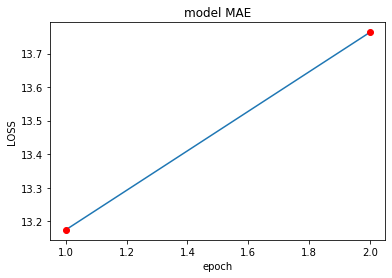

In [28]:
import matplotlib. pyplot as plt 
loss_curve(history)

## generate submission

In [38]:
from tqdm import tqdm

submission = pd.read_csv('../data/sample_submission.csv', index_col='seg_id', dtype={"time_to_failure": np.float32})

for i, seg_id in enumerate(tqdm(submission.index)):
  #  print(i)
    seg = pd.read_csv('../data/test/' + seg_id + '.csv')
    raw_x = seg['acoustic_data'].values
    X = create_X(raw_x)
    X = torch.from_numpy(X).float()
    lstm.eval()
    out = lstm(X.view(1, 150, 14))
    print(out)

NameError: name 'X_data' is not defined